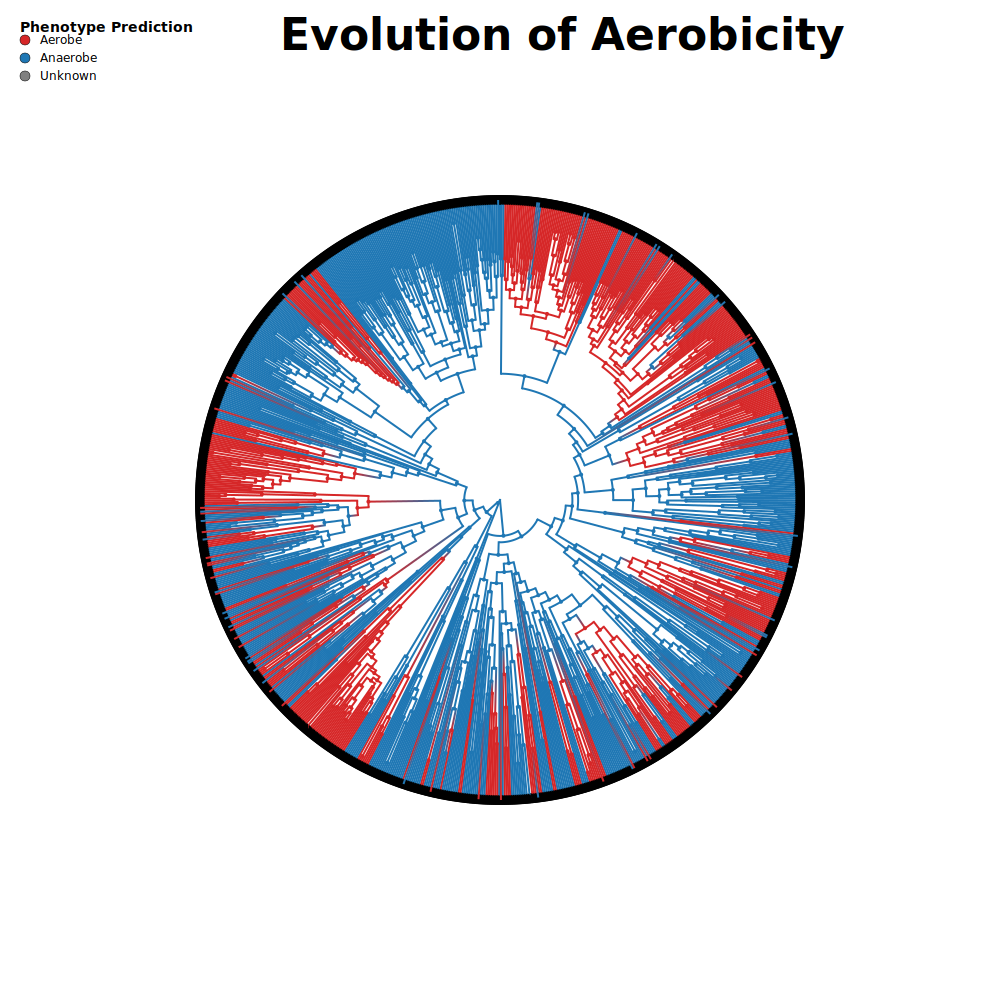

In [2]:
import pandas as pd
import ete3
import phylustrator as ph

# 1. Load and Clean the Predictions
# ---------------------------------------------------------
df = pd.read_csv("../data/aerobic_predictions.tsv", sep="\t")

# Function to clean names: "AABM5X1(0)" -> "AABM5X1"
def clean_name(name):
    return name.split("(")[0]

# Apply cleaning to the 'node' column
df['clean_name'] = df['node'].apply(clean_name)

# Create a mapping dictionary: { "NodeName": "aerobe/anaerobe" }
# We use the 'prediction' column based on your snippet
type_mapping = pd.Series(df.prediction.values, index=df.clean_name).to_dict()


# 2. Load and Annotate the Tree
# ---------------------------------------------------------
t = ete3.Tree("../data/ReferenceTree.nwk", format=1)

# Annotate every node in the tree with its predicted type
# We default to "unknown" if a node is not in your TSV file
for n in t.traverse():
    # Use the cleaned name if it's a leaf, or the standard name if internal
    # (or just try looking up n.name directly if your cleaning logic handles both)
    if n.name in type_mapping:
        n.add_feature("phenotype", type_mapping[n.name])
    else:
        n.add_feature("phenotype", "unknown")

# 3. Setup Colors
COLOR_MAP = {"aerobe": "#D62728", "anaerobe": "#1F77B4", "unknown": "grey"}

branch2color = {}
transitions = []

for n in t.traverse():
    if n.is_root(): continue
    
    my_type = n.phenotype
    parent_type = n.up.phenotype
    
    # ALWAYS use the node's OWN phenotype color for branch2color.
    # This ensures the Node Circle and Horizontal Arc (Shoulder) are colored correctly (e.g. Blue).
    branch2color[n] = COLOR_MAP.get(my_type, "grey")
    
    # Detect Transition
    if my_type != parent_type:
        transitions.append(n)

# 4. Draw Main Tree
style = ph.TreeStyle(radius=300, node_size=2)
drawer = ph.TreeDrawer(t, style=style)

# KEY CHANGE: We pass the 'transitions' list to hide_radial_lines.
# The drawer will draw the Blue Arc and Blue Node, but SKIP the vertical line connecting to the parent.
drawer.draw(branch2color=branch2color, hide_radial_lines=transitions)

# 5. Fill Gaps with Gradients
for n in transitions:
    my_color = COLOR_MAP.get(n.phenotype, "grey")
    parent_color = COLOR_MAP.get(n.up.phenotype, "grey")
    
    # Draw ONLY the gradient line (Red -> Blue)
    drawer.gradient_branch(n, colors=(parent_color, my_color))

# 6. Add Legend
legend_map = {
    "Aerobe": "#D62728",     # Red
    "Anaerobe": "#1F77B4",   # Blue
    "Unknown": "grey"
}

drawer.add_legend(
    title="Phenotype Prediction", 
    mapping=legend_map, 
    position="top-left", 
    symbol="circle"
)

drawer.add_text("Evolution of Aerobicity", x= -220, y=-450, size=44, font_weight="bold", anchor="start")

display(drawer.d)

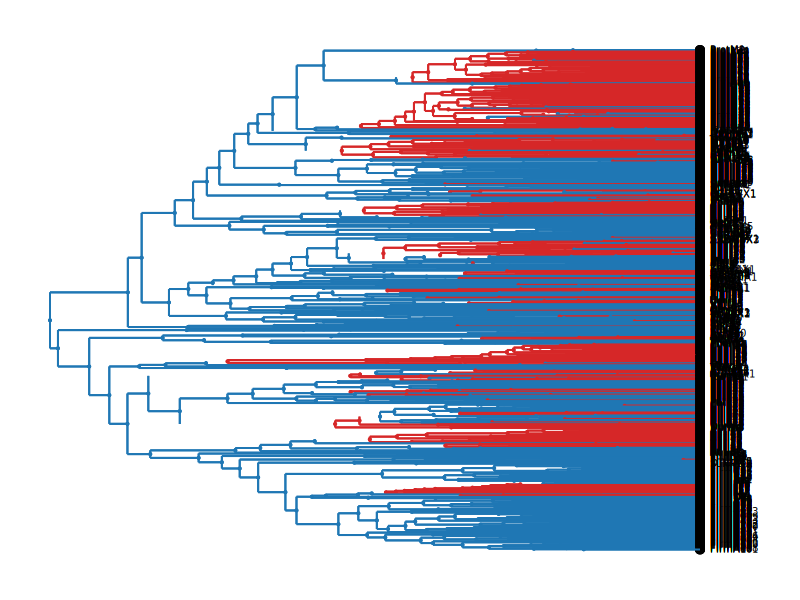

In [5]:

# 2. Draw Rectangular
style = ph.TreeStyle(width=800, height=600, branch_size=2)

# Use VerticalTreeDrawer
drawer = ph.VerticalTreeDrawer(t, style=style)

# The same drawing logic works!
drawer.draw(branch2color=branch2color, hide_radial_lines=transitions)


# ... (Now draw) ...
drawer.draw(branch2color=branch2color, hide_radial_lines=transitions)

# Add names (simpler in rectangular mode)
drawer.add_leaf_names(text_size=10)

display(drawer.d)

In [6]:
# 1. Define Colors
# -----------------------------
COLOR_MAP = {
    "aerobe": "#D62728",    # Red
    "anaerobe": "#1F77B4",  # Blue
    "unknown": "grey"
}

# 2. Build Drawing Instructions
# -----------------------------
branch2color = {}   # Dictionary for solid branches
transitions = []    # List of nodes where a transition occurs

for n in t.traverse():
    # A. Get colors
    my_type = getattr(n, "phenotype", "unknown")
    my_color = COLOR_MAP.get(my_type, "grey")
    
    # B. Assign Solid Color to EVERYTHING (Root included)
    # This ensures the Node circles and Horizontal arcs are always colored.
    branch2color[n] = my_color
    
    # C. Detect Transitions (Skip root as it has no parent)
    if not n.is_root():
        parent_type = getattr(n.up, "phenotype", "unknown")
        
        # If phenotype changed, mark it as a transition.
        # We will hide the default black line for these later.
        if my_type != parent_type:
            transitions.append(n)

print(f"Found {len(transitions)} evolutionary transitions.")

Found 150 evolutionary transitions.


Figure saved to aerobic_radial.svg


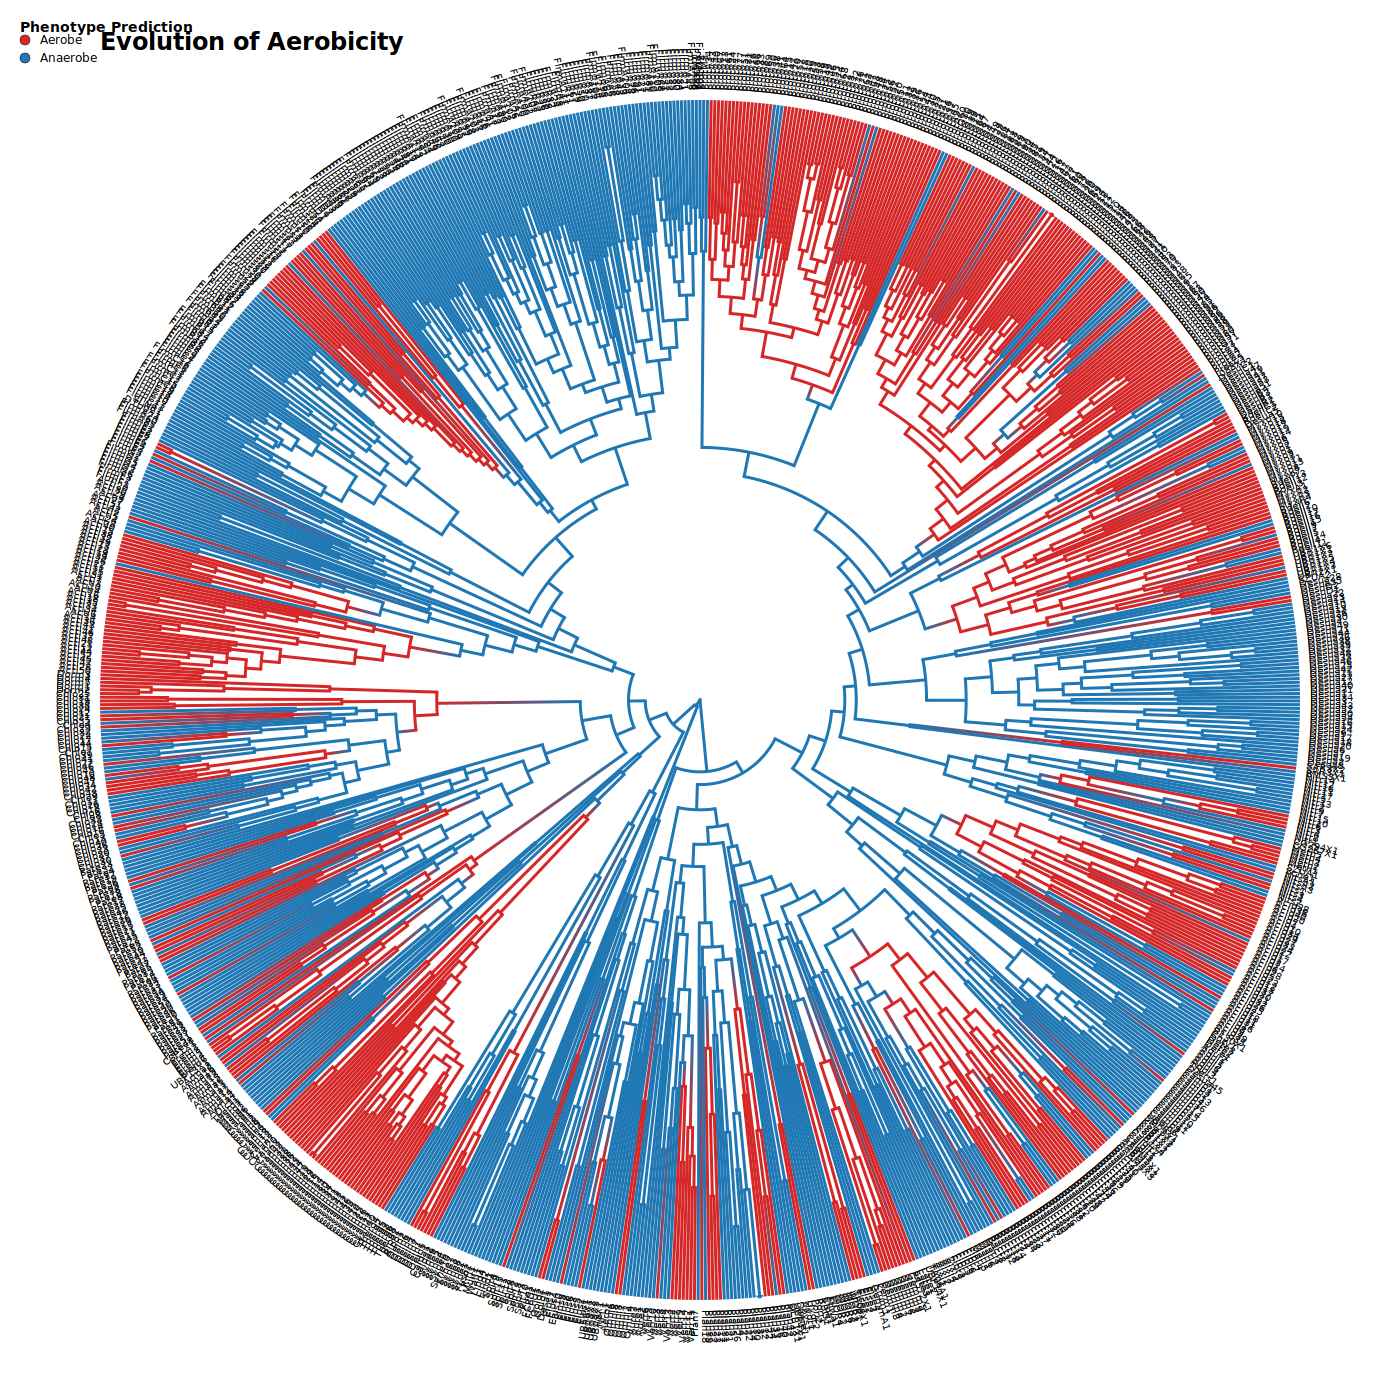

In [12]:
# 1. Initialize Radial Drawer
# -----------------------------
# mode='r' means "Real" branch lengths (Phylogram)
style = ph.TreeStyle(
    radius=600, 
    width=1400, 
    height=1400, 
    branch_size=3,
    node_size=0,
    leaf_color="none" # Hide default leaf dots (we'll add text instead)
)

drawer = ph.TreeDrawer(t, style=style)

# 2. Draw Main Tree
# -----------------------------
# hide_radial_lines=transitions: This tells the drawer to skip drawing 
# the vertical lines for transition nodes (leaving a gap).
drawer.draw(branch2color=branch2color, hide_radial_lines=transitions)

# 3. Fill Transitions with Gradients
# -----------------------------
for n in transitions:
    my_color = COLOR_MAP.get(n.phenotype, "grey")
    parent_color = COLOR_MAP.get(n.up.phenotype, "grey")
    
    # Draw gradient from Parent -> Child
    drawer.gradient_branch(n, colors=(parent_color, my_color), size=3)

# 4. Add Decorations
# -----------------------------
# Add Leaf Names (Auto-aligned)
drawer.add_leaf_names(text_size=10, padding=10)

# Add Legend
drawer.add_legend(
    title="Phenotype Prediction",
    mapping={"Aerobe": COLOR_MAP["aerobe"], "Anaerobe": COLOR_MAP["anaerobe"]},
    position="top-left",
    symbol="circle"
)

# Add Main Title
drawer.add_text("Evolution of Aerobicity", x=-600, y=-650, size=24, font_weight="bold", anchor="start")

# 5. Display and Save
# -----------------------------
drawer.save_figure("aerobic_radial.svg")
display(drawer.d)

Figure saved to aerobic_linear.svg


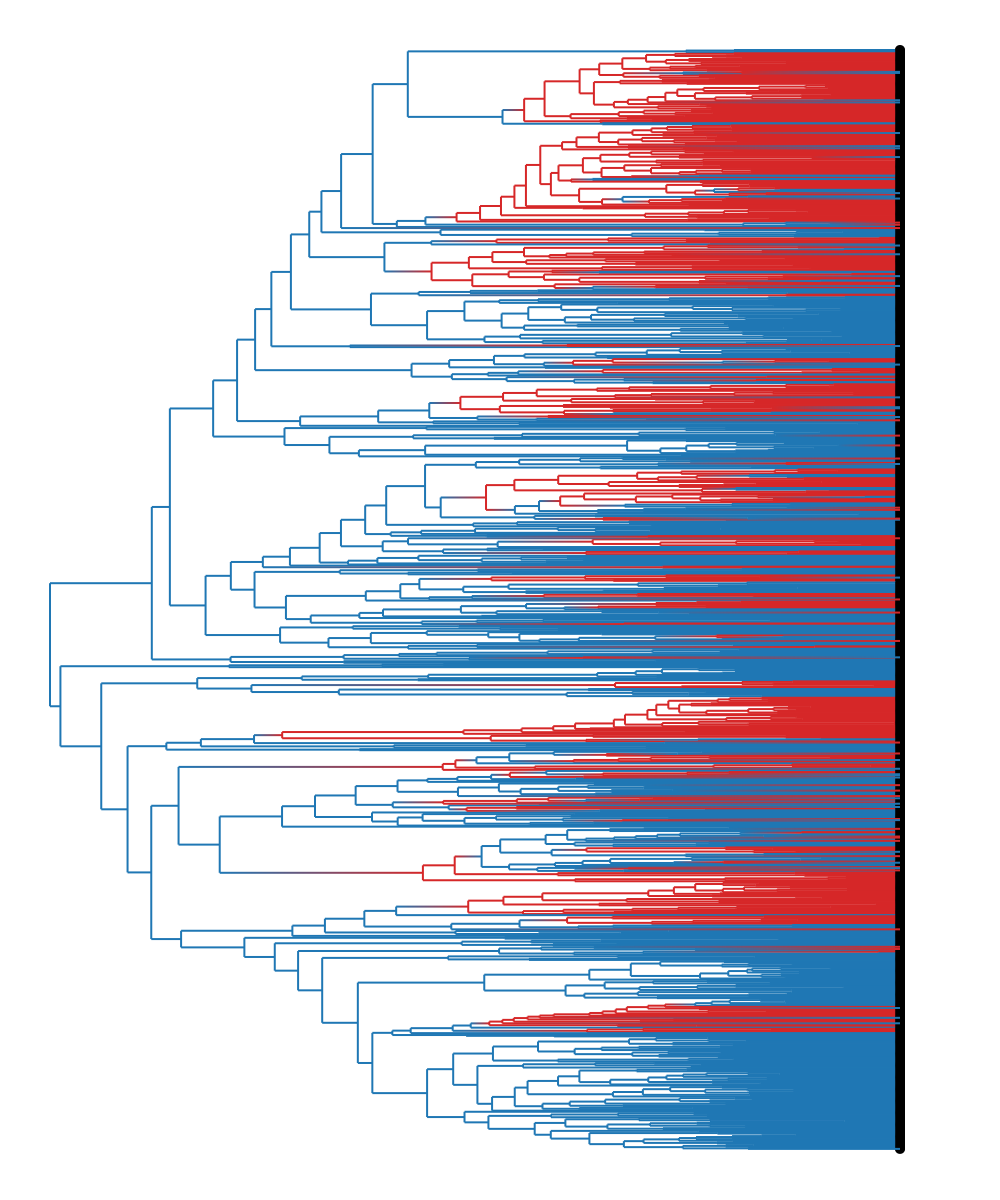

In [11]:
# 1. Initialize Vertical Drawer
# -----------------------------
# A tall canvas is good for linear trees with many leaves
linear_style = ph.TreeStyle(
    width=1000, 
    height=1200, 
    branch_size=2,
    node_size=0
)

v_drawer = ph.VerticalTreeDrawer(t, style=linear_style)

# 2. Draw Main Tree
# -----------------------------
# Re-use the same branch2color and transitions list!
v_drawer.draw(branch2color=branch2color, hide_radial_lines=transitions)

# 3. Fill Transitions (Linear Gradients)
# -----------------------------
for n in transitions:
    my_color = COLOR_MAP.get(n.phenotype, "grey")
    parent_color = COLOR_MAP.get(n.up.phenotype, "grey")
    v_drawer.gradient_branch(n, colors=(parent_color, my_color), size=2)

# 4. Add Names
# -----------------------------
#v_drawer.add_leaf_names(text_size=10, padding=5)

# 5. Display and Save
# -----------------------------
v_drawer.save_figure("aerobic_linear.svg")
display(v_drawer.d)